# Analysis of Electric Vehicle Charging Transactions (Employees)

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Display all columns
pd.set_option('display.max_columns', None)

# Set visualization style
sns.set_style('darkgrid')

In [2]:
# Read in the file
employee_data = pd.read_excel(
    'SEND Employee_Charging sessions data.xlsx',
    header=3,
    parse_dates = [2, 3]
)

In [3]:
employee_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Nutzergruppe                   128 non-null    object        
 1   Kostenstelle                   0 non-null      float64       
 2   Eingesteckt am                 128 non-null    datetime64[ns]
 3   Ausgesteckt am                 129 non-null    object        
 4   Ladedauer                      129 non-null    object        
 5   Zeit angesteckt                129 non-null    object        
 6   Standort                       128 non-null    object        
 7   Ladestation                    128 non-null    object        
 8   Anschluss                      128 non-null    object        
 9   EVSE-ID                        128 non-null    object        
 10  Kommentar                      0 non-null      float64       
 11  Preis pro kWh      

The data contains **128** rows and **23** features defined as follows:
- Nutzergruppe (User group) - This defines the group of people using the product, with no missing values.
- Kostenstelle (Cost centre) - This is an empty feature.
- Eingesteckt am (Plugged in) - This is the time when the electric vehicle was plugged in, with no missing values.
- Ausgesteckt am (Unplugged) - This is the time when the electric vehicle was unplugged, with no missing values.
- Ladedauer (Charge time) - This is the length of time the vehicle charges, with no missing values.
- Zeit angesteckt (Blocking time) - This is the time period when the vehicle is connected to the charge station, with no missing values.
- Standort (Location) - This is the location of the charge station, with no missing values.
- Ladestation (Charge station) - This contains the ID of the charge station, with no missing values.
- Anschluss (Connections) - This contains the ID of the charging point in a station, with no missing values.
- EVSE-ID (Car registration number) - This defines the registration number of the vehicle, with no missing values.
- Kommentar (Comment) - This is an empty feature.
- Preis pro kWh (Price per kWh) - This defines the price per kilowatts-hour of electricity used, with no missing values.
- Verbrauch (Consumption) - This is the amount of electricity used (kWh), with no missing values.
- Netto Kosten (Net cost) - This is the net cost (kWh), with no missing values.
- Steuersatz (Tax rate) - This is the rate at which tax (kWh) is deducted in percentage, with no missing values.
- Steuer Kosten (Tax cost) - This is the tax cost (kWh), with no missing values.
- Brutto Kosten (Gross cost) - This is the initial cost (kWh) before any deduction, with no missing values.
- Parkgebühr Tarif (Parking fee tariff) - This is the amount charged for parking (per minute), with no missing values.
- Netto Kosten (Parkgebühr) (Net cost parking fee) - This is the net cost of parking, with no missing values.
- Steuersatz (Parkgebühr) (Tax rate of parking) - This is the tax rate (percentage) of parking, with no missing values.
- Steuer Kosten (Parkgebühr) (Tax cost of parking) - This defines the tax cost of parking, with no missing values.
- Brutto Kosten (Parkgebühr) (Gross cost of parking) - This is the initial cost of parking before any deduction, with no missing values.
- Kosten gesamt (Total cost) - This defines the total cost accrued, with no missing values. 

## Data Preprocessing

In [4]:
# Drop last two rows (redundant data)
employee_data.drop([128, 129], inplace=True)

In [5]:
# Convert unplugged feature to datetime
employee_data['Ausgesteckt am'] = pd.to_datetime(employee_data['Ausgesteckt am'])

In [6]:
# Create a function to convert duration to hours
def duration_to_hours(duration):
    parts = duration.split(' ')
    hours = 0
    minutes = 0
    seconds = 0

    for part in parts:
        if 'h' in part:
            hours = int(part[:-1])
        elif 'm' in part:
            minutes = int(part[:-1])
        elif 's' in part:
            seconds = int(part[:-1])
    return (hours + (minutes / 60) + seconds / 3600)

In [7]:
# Convert Charge time to hours only
employee_data['Charge time'] = employee_data['Ladedauer'].apply(duration_to_hours)

# Convert Blocking time to hours only
employee_data['Blocking time'] = employee_data['Zeit angesteckt'].apply(duration_to_hours)

In [109]:
# Extract month when vehicles were plugged and unplugged
employee_data['Plugged_in_month'] = employee_data['Eingesteckt am'].dt.month
employee_data['Unplugged_month'] = employee_data['Ausgesteckt am'].dt.month

# Extract week when vehicles were plugged and unplugged
employee_data['Plugged_in_week'] = employee_data['Eingesteckt am'].dt.isocalendar().week.astype('int')
employee_data['Unplugged_week'] = employee_data['Ausgesteckt am'].dt.isocalendar().week.astype('int')

# Extract day when vehicles were plugged and unplugged
employee_data['Plugged_in_day'] = employee_data['Eingesteckt am'].dt.day
employee_data['Unplugged_day'] = employee_data['Ausgesteckt am'].dt.day

# Extract time when vehicles were plugged and unplugged
employee_data['Plugged_in_time'] = employee_data['Eingesteckt am'].dt.time
employee_data['Unplugged_time'] = employee_data['Ausgesteckt am'].dt.time

In [110]:
employee_data_daytime = employee_data.set_index('Ausgesteckt am').between_time('6:00', '18:00').reset_index()

In [111]:
employee_data_nighttime = employee_data.set_index('Ausgesteckt am').between_time('18:01', '5:59').reset_index()

## Exploratory Data Analysis

### Number of unique employee users

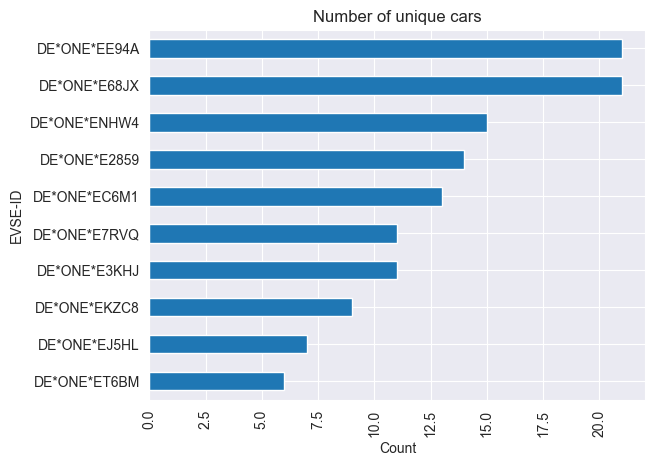

In [74]:
employee_data['EVSE-ID'].value_counts(ascending=True).plot(kind='barh')
plt.xlabel('Count')
plt.xticks(rotation=90)
plt.title('Number of unique cars')
plt.savefig('Images/unique-employees.png', dpi=300, bbox_inches='tight')
plt.show()

There is only one user group, and they are employees.

### Rate/frequency of charge (Overall)

In [112]:
employee_data_september = employee_data[employee_data['Plugged_in_month'] == 9]
employee_data_october = employee_data[employee_data['Plugged_in_month'] == 10]
employee_data_november = employee_data[employee_data['Plugged_in_month'] == 11]

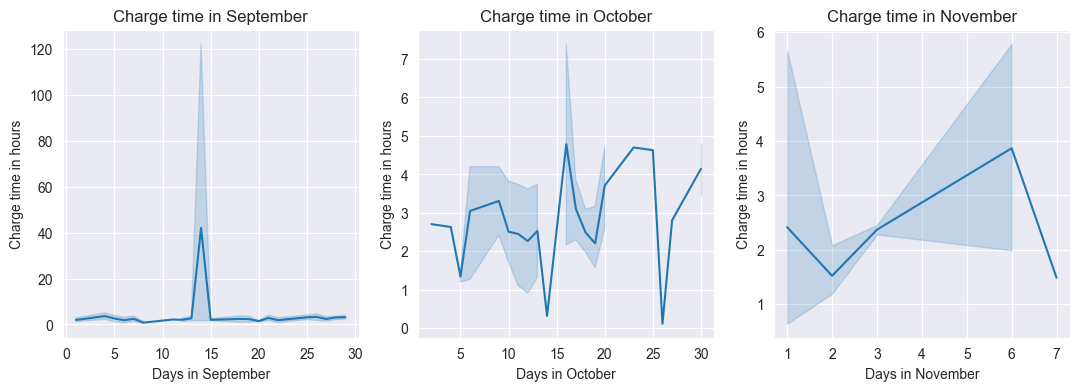

In [113]:
# Rate of charge (daily)
fig, ax = plt.subplots(1, 3, figsize=(13,4))
sns.lineplot(
    data=employee_data_september,
    x='Plugged_in_day',
    y='Charge time',
    ax=ax[0]
)
ax[0].set_xlabel('Days in September')
ax[0].set_ylabel('Charge time in hours')
ax[0].set_title('Charge time in September')

# Rate of charge (weekly)
sns.lineplot(
    data=employee_data_october,
    x='Plugged_in_day',
    y='Charge time',
    ax=ax[1]
)
ax[1].set_xlabel('Days in October')
ax[1].set_ylabel('Charge time in hours')
ax[1].set_title('Charge time in October')

# Rate of charge (monthly)
sns.lineplot(
    data=employee_data_november,
    x='Plugged_in_day',
    y='Charge time',
    ax=ax[2]
)
ax[2].set_xlabel('Days in November')
ax[2].set_ylabel('Charge time in hours')
ax[2].set_title('Charge time in November')
plt.savefig('Images/rate-of-charge.png')
plt.show()

In September, the charge time had a sharp increase up to **122 hours**, on the **14th**. The charge time in October was random, with the minimum being **0.11** hours (**7** minutes) and the maximum being **7.395** hours (**7** hours **23** minutes). In November, the minimum charge time was **0.64** hours (**38** minutes) and the maximum charge time was **5.78** hours (**5** hours **47** minutes).

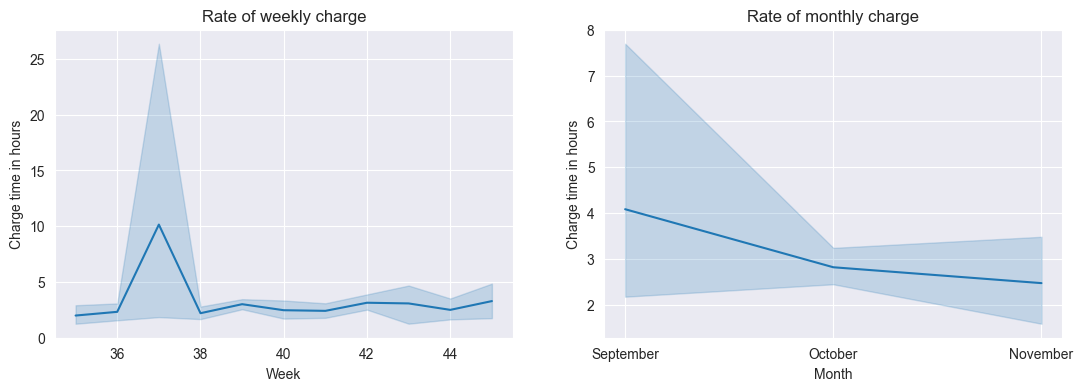

In [115]:
# Rate of charge (daily)
fig, ax = plt.subplots(1, 2, figsize=(13,4))
# sns.lineplot(
#     data=employee_data,
#     x='Plugged_in_day',
#     y='Charge time',
#     ax=ax[0]
# )
# ax[0].set_xlabel('Days')
# ax[0].set_ylabel('Charge time in hours')
# ax[0].set_title('Rate of daily charge (Fig 1.1)')

# Rate of charge (weekly)
sns.lineplot(
    data=employee_data,
    x='Plugged_in_week',
    y='Charge time',
    ax=ax[0]
)
ax[0].set_xlabel('Week')
ax[0].set_ylabel('Charge time in hours')
ax[0].set_title('Rate of weekly charge')

# Rate of charge (monthly)
sns.lineplot(
    data=employee_data,
    x='Plugged_in_month',
    y='Charge time',
    ax=ax[1]
)
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Charge time in hours')
ax[1].set_xticks([9, 10, 11], labels=['September', 'October', 'November'])
ax[1].set_title('Rate of monthly charge')
plt.savefig('Images/rate-of-charge-2.png')
plt.show()

**Fig 1.2** shows the rate of weekly charge which also fluctuates between **1** and **4** hours. In the **37th** week however, there was a sharp increase in charge time up to **26** hours. **Fig 1.3** shows a decline in charge time from September to November.

### Rate of charge over the weekend

In [18]:
number_of_weeks = employee_data['Plugged_in_week'].max() - employee_data['Plugged_in_week'].min()
number_of_weeks

10

In [19]:
employee_data_weekend = employee_data[employee_data['Eingesteckt am'].dt.day_name().isin(['Saturday', 'Sunday'])]

In [20]:
employee_data_weekend['Weekend'] = employee_data['Eingesteckt am'].dt.day_name()

In [81]:
employee_data_weekend[['EVSE-ID', 'Weekend', 'Eingesteckt am', 'Ausgesteckt am', 'Zeit angesteckt', 'Ladedauer', 'Standort', 'Ladestation', 'Charge time']]

,EVSE-ID,Weekend,Eingesteckt am,Ausgesteckt am,Zeit angesteckt,Ladedauer,Standort,Ladestation,Charge time
73,DE*ONE*E68JX,Saturday,2023-10-14 16:01:52.768,2023-10-14 16:21:24.712,0h 19m 32s,0h 19m 15s,Ulanweg,ABL_10332049,0.320833


The data was recorded for 10 weeks, out of which there was only one Saturday, with a charge time of **0.320833** hours (**19** minutes **15** seconds).

### Usage occupancy of charge points

In [22]:
employee_data['Anschluss'] = employee_data['Anschluss'].map({
    '1': 'Ladepunkt 1',
    'Ladepunkt 1': 'Ladepunkt 1',
    '2': 'Ladepunkt 2',
    'Ladepunkt 2': 'Ladepunkt 2',
    '3': 'Ladepunkt 3',
    'Ladepunkt 3': 'Ladepunkt 3',
    '4': 'Ladepunkt 4',
    'Ladepunkt 4': 'Ladepunkt 4'
})

In [116]:
employee_data_september_charge_point = employee_data[employee_data['Plugged_in_month'] == 9]
employee_data_october_charge_point = employee_data[employee_data['Plugged_in_month'] == 10]
employee_data_november_charge_point = employee_data[employee_data['Plugged_in_month'] == 11]

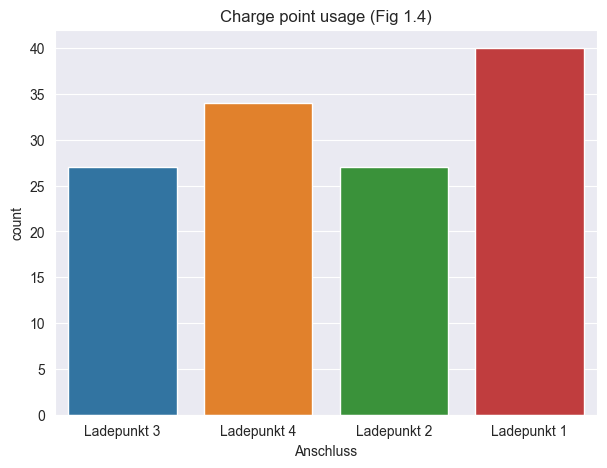

In [27]:
plt.figure(figsize=(7,5))
sns.countplot(
    data=employee_data,
    x='Anschluss'
)
#ax.set_xticks(labels=['Charging point 1', 'Charging point 2', 'Charging point 3', 'Charging point 4'])
plt.title('Charge point usage (Fig 1.4)')
plt.show()

Charging point **1** was the most used. Charging points **2** and **3** had the same usage count. Charging point **4** was the second most used.

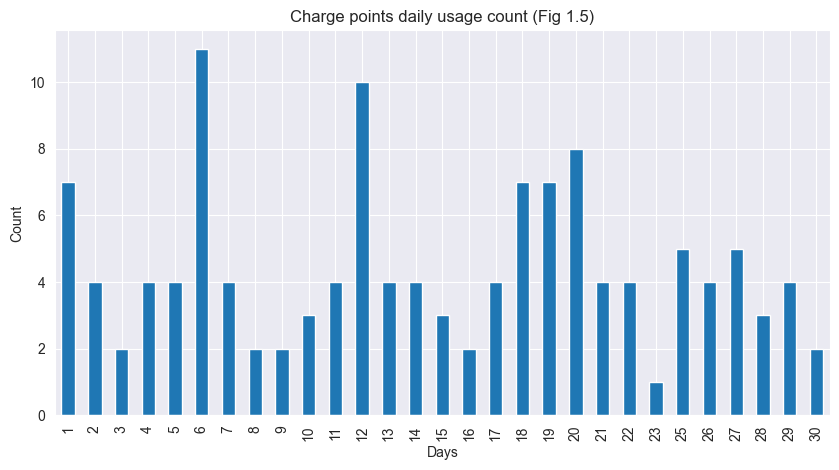

In [28]:
# Daily usage of charge points
plt.figure(figsize=(10,5))
employee_data.groupby('Plugged_in_day')['Anschluss'].count().plot(kind='bar')
plt.xlabel('Days')
plt.ylabel('Count')
plt.title('Charge points daily usage count (Fig 1.5)')

plt.show()

Day **6** had the highest charge point usage count while day **23** had the lowest charge point usage.

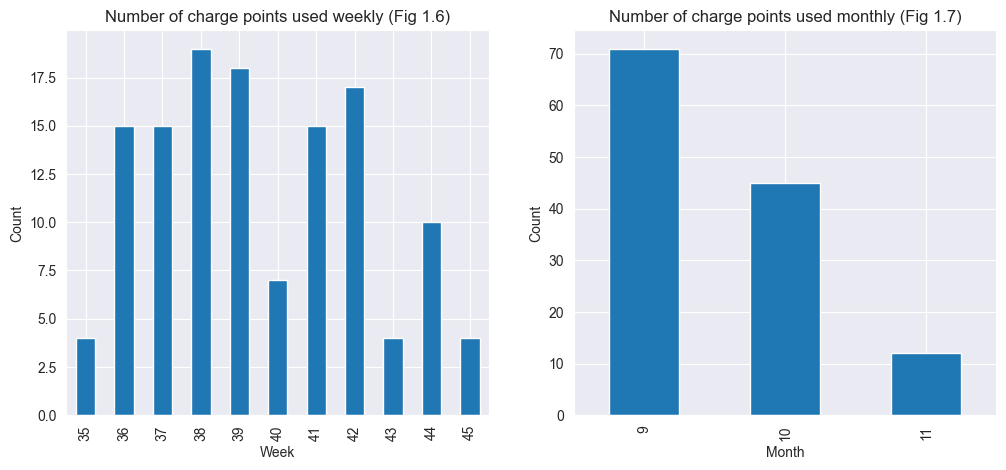

In [164]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

# Weekly usage of charge points
employee_data.groupby('Plugged_in_week')['Anschluss'].count().plot(kind='bar', ax=ax[0])
ax[0].set_xlabel('Week')
ax[0].set_ylabel('Count')
ax[0].set_title('Number of charge points used weekly (Fig 1.6)')

# Monthly usage of charge points
employee_data.groupby('Plugged_in_month')['Anschluss'].count().plot(kind='bar', ax=ax[1])
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Count')
#ax[2].set_xticks([9, 10, 11], labels=['September', 'October', 'November'])
ax[1].set_title('Number of charge points used monthly (Fig 1.7)')

plt.show()

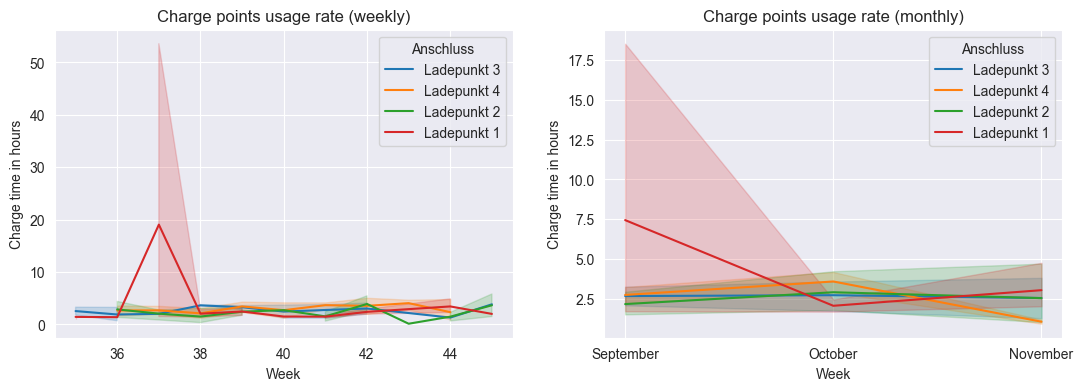

In [131]:
fig, ax = plt.subplots(1, 2, figsize=(13,4))
sns.lineplot(
    data=employee_data,
    x='Plugged_in_week',
    y='Charge time',
    hue='Anschluss',
    ax=ax[0]
)
ax[0].set_xlabel('Week')
ax[0].set_ylabel('Charge time in hours')
ax[0].set_title('Charge points usage rate (weekly)')
#ax[0].set_ylim(0,20)

# Rate of charge (weekly)
sns.lineplot(
    data=employee_data,
    x='Plugged_in_month',
    y='Charge time',
    hue='Anschluss',
    ax=ax[1]
)
ax[1].set_xlabel('Week')
ax[1].set_ylabel('Charge time in hours')
ax[1].set_title('Charge points usage rate (monthly)')
ax[1].set_xticks([9, 10, 11], labels=['September', 'October', 'November'])
plt.savefig('Images/usage-occupancy-of-charge-points-weekly-monthly')
plt.show()

Week **38** had the highest charge point usage

In [80]:
#employee_data.groupby('Plugged_in_day')['Charge time'].sum()
#employee_data['Charge time'].max()

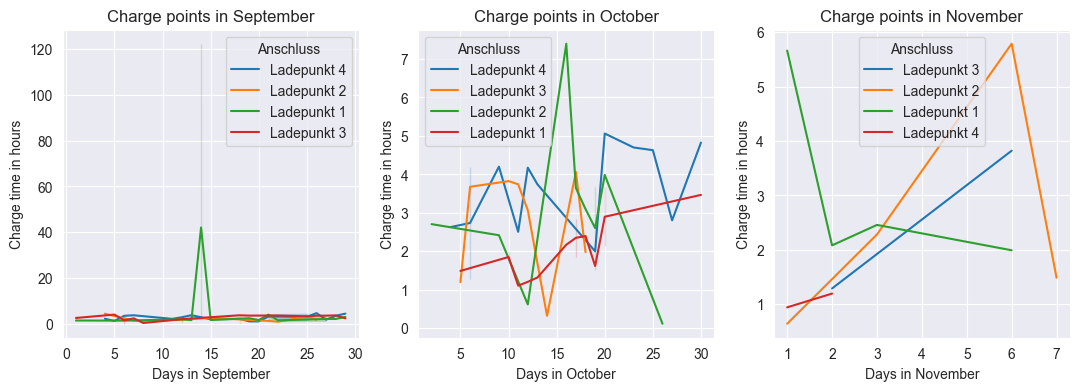

In [86]:
# Rate of charge (daily)
fig, ax = plt.subplots(1, 3, figsize=(13,4))
sns.lineplot(
    data=employee_data_september_charge_point,
    x='Plugged_in_day',
    y='Charge time',
    hue='Anschluss',
    ax=ax[0]
)
ax[0].set_xlabel('Days in September')
ax[0].set_ylabel('Charge time in hours')
ax[0].set_title('Charge points in September')

# Rate of charge (weekly)
sns.lineplot(
    data=employee_data_october_charge_point,
    x='Plugged_in_day',
    y='Charge time',
    hue='Anschluss',
    ax=ax[1]
)
ax[1].set_xlabel('Days in October')
ax[1].set_ylabel('Charge time in hours')
ax[1].set_title('Charge points in October')

# Rate of charge (monthly)
sns.lineplot(
    data=employee_data_november_charge_point,
    x='Plugged_in_day',
    y='Charge time',
    hue='Anschluss',
    ax=ax[2]
)
ax[2].set_xlabel('Days in November')
ax[2].set_ylabel('Charge time in hours')
ax[2].set_title('Charge points in November')
plt.savefig('Images/usage-occupancy-of-charge-points-daily')
plt.show()

In September and October, the charge time in all four charge points is random. The charge point with the highest usage in September was **Charge point 1** with **122** hours while the lowest was **Charge point 3** with **0.33** hours. In October, **Charge point 2** had the highest usage with **7.395** hours while the lowest was **Charging point 2** with **0.11** hours. In November, **Charge point 2** had the highest usage with **5.788** hours although, it also had the lowest usage with **0.64** hours. This is also evident in the table below.

In [30]:
table = pd.pivot_table(employee_data, values='Charge time', columns=['Plugged_in_month', 'Plugged_in_day'], index=['Anschluss'], aggfunc="sum")

In [32]:
table = table.rename(columns={
    'Plugged_in_month': 'Month',
    'Plugged_in_day': 'Day'
})

In [33]:
table

Plugged_in_month  November                                         October  \
Plugged_in_day          1         2         3         6         7       2    
Anschluss                                                                    
Ladepunkt 1       5.662500  2.081667  2.457222  1.991111       NaN     NaN   
Ladepunkt 2       0.640833       NaN  2.281667  5.788333  1.486389   2.705   
Ladepunkt 3            NaN  1.289167       NaN  3.821667       NaN     NaN   
Ladepunkt 4       0.941944  1.194722       NaN       NaN       NaN     NaN   

Plugged_in_month                                                          \
Plugged_in_day      4         5         6         9         10        11   
Anschluss                                                                  
Ladepunkt 1        NaN  1.488889       NaN       NaN  3.701111  1.106389   
Ladepunkt 2        NaN       NaN       NaN  2.416667       NaN       NaN   
Ladepunkt 3        NaN  1.195833  3.676389       NaN  3.823333  3.740833   
Ladepunkt 4       2.63       NaN  5.470278  4.198611       NaN  2.505278   

Plugged_in_month                                                           \
Plugged_in_day          12        13        14     16        17        18   
Anschluss                                                                   
Ladepunkt 1       1.205278  1.316944       NaN  2.170  4.698056  2.395833   
Ladepunkt 2       0.618056       NaN       NaN  7.395  3.642500  3.097500   
Ladepunkt 3       3.065556       NaN  0.320833    NaN  4.062778  1.977222   
Ladepunkt 4       4.173056  3.740278       NaN    NaN       NaN       NaN   

Plugged_in_month                                                              \
Plugged_in_day          19        20        23        25        26        27   
Anschluss                                                                      
Ladepunkt 1       1.615833  5.794167       NaN       NaN       NaN       NaN   
Ladepunkt 2       5.205833  3.983611       NaN       NaN  0.116389       NaN   
Ladepunkt 3            NaN       NaN       NaN       NaN       NaN       NaN   
Ladepunkt 4       1.998056  5.060556  4.697778  4.628056       NaN  2.804167   

Plugged_in_month           September                                          \
Plugged_in_day          30        1         4         5         6         7    
Anschluss                                                                      
Ladepunkt 1       3.465278  2.839167       NaN       NaN  1.365833       NaN   
Ladepunkt 2            NaN       NaN  8.747500       NaN       NaN  1.366389   
Ladepunkt 3            NaN  5.061389       NaN  4.004167  4.581944  2.349722   
Ladepunkt 4       4.824444       NaN  2.215556  1.191111  3.464722  3.705000   

Plugged_in_month                                                              \
Plugged_in_day          8       11        12        13          14        15   
Anschluss                                                                      
Ladepunkt 1            NaN     NaN  3.862500  1.599167  126.114167  1.637778   
Ladepunkt 2       1.283333     NaN  3.570833       NaN         NaN  2.544444   
Ladepunkt 3       0.332222     NaN  2.002778       NaN         NaN       NaN   
Ladepunkt 4            NaN  2.1425  2.844167  3.746111         NaN  1.938056   

Plugged_in_month                                                              \
Plugged_in_day          18        19        20        21        22        25   
Anschluss                                                                      
Ladepunkt 1            NaN  2.409444  4.859722  3.977500  2.979167       NaN   
Ladepunkt 2       3.800278       NaN       NaN  1.225278  0.903056  3.080833   
Ladepunkt 3       3.702222  3.563333       NaN       NaN  3.606111  3.251111   
Ladepunkt 4       2.142778  1.045000  1.034722  6.267500       NaN  6.148333   

Plugged_in_month                                          
Plugged_in_day          26        27        28        29  
Anschluss         

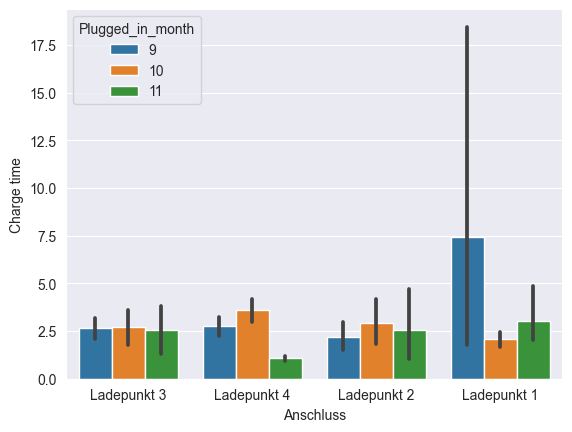

In [119]:
sns.barplot(
    data=employee_data,
    x='Anschluss',
    y='Charge time',
    hue='Plugged_in_month'
)
plt.show()

### Blocking time

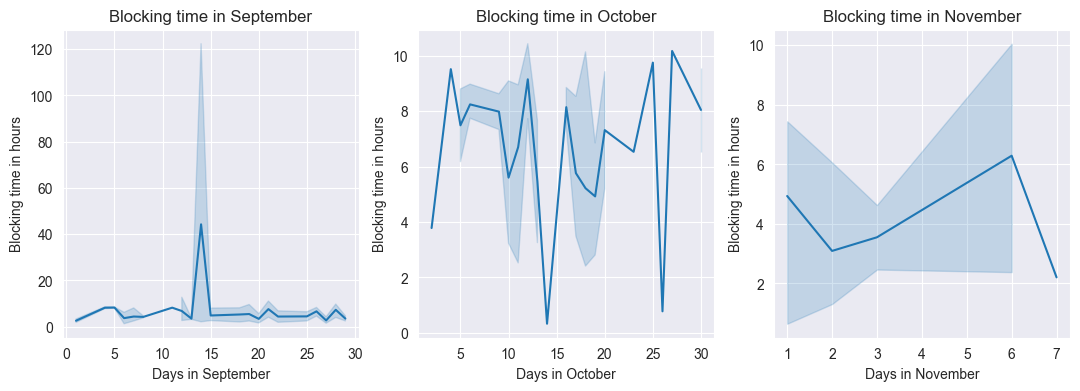

In [91]:
# Rate of charge (daily)
fig, ax = plt.subplots(1, 3, figsize=(13,4))
sns.lineplot(
    data=employee_data_september,
    x='Plugged_in_day',
    y='Blocking time',
    ax=ax[0]
)
ax[0].set_xlabel('Days in September')
ax[0].set_ylabel('Blocking time in hours')
ax[0].set_title('Blocking time in September')

# Rate of charge (weekly)
sns.lineplot(
    data=employee_data_october,
    x='Plugged_in_day',
    y='Blocking time',
    ax=ax[1]
)
ax[1].set_xlabel('Days in October')
ax[1].set_ylabel('Blocking time in hours')
ax[1].set_title('Blocking time in October')

# Rate of charge (monthly)
sns.lineplot(
    data=employee_data_november,
    x='Plugged_in_day',
    y='Blocking time',
    ax=ax[2]
)
ax[2].set_xlabel('Days in November')
ax[2].set_ylabel('Blocking time in hours')
ax[2].set_title('Blocking time in November')
plt.savefig('Images/blocking-time-daily')
plt.show()

In [65]:
#employee_data_november[employee_data_november['Blocking time'] == employee_data_november['Blocking time'].min()]['Zeit angesteckt']

In September, the blocking time had a sharp increase on the **14th** for **122 hours**. In October, there were random hours of blocking time, with the minimum being **0.32** hours (**19** minutes) and the maximum being **11.11** hours (**11** hours **6** minutes). In November, the minimum blocking time was **0.64** hours (**38** minutes **50** seconds) and the maximum blocking time was **10.04** hours (**10** hours **2** minutes).

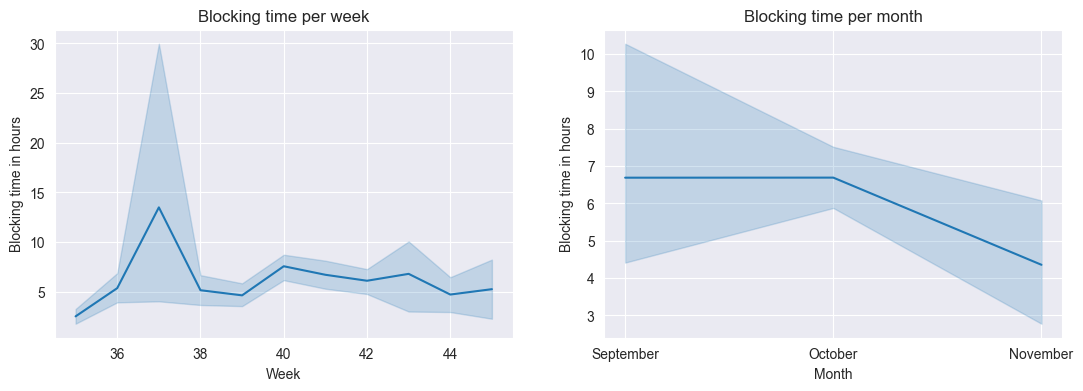

In [118]:
fig, ax = plt.subplots(1, 2, figsize=(13,4))

# Rate of charge (Daily)
# sns.lineplot(
#     data=employee_data,
#     x='Plugged_in_day',
#     y='Blocking time',
#     ax=ax[0]
# )
# ax[0].set_xlabel('Days')
# ax[0].set_ylabel('Blocking time in hours')
# ax[0].set_title('Blocking time (Fig 1.8)')

# Rate of charge (weekly)
sns.lineplot(
    data=employee_data,
    x='Plugged_in_week',
    y='Blocking time',
    ax=ax[0]
)
ax[0].set_xlabel('Week')
ax[0].set_ylabel('Blocking time in hours')
ax[0].set_title('Blocking time per week')
#
# Rate of charge (monthly)
sns.lineplot(
    data=employee_data,
    x='Plugged_in_month',
    y='Blocking time',
    ax=ax[1]
)
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Blocking time in hours')
ax[1].set_xticks([9, 10, 11], labels=['September', 'October', 'November'])
ax[1].set_title('Blocking time per month')
plt.savefig('Images/blocking-time-weekly-monthly')
plt.show()

Weekly, the blocking time has a similar rate as charging time. There was an increase up to **30** hours on the **37th** week. The blocking time seems constant throughout September but it began to decrease from October to November.

### Hogging time

In [38]:
employee_data['Hogging time'] = employee_data['Blocking time'] - employee_data['Charge time']

In [119]:
employee_data_september = employee_data[employee_data['Plugged_in_month'] == 9]
employee_data_october = employee_data[employee_data['Plugged_in_month'] == 10]
employee_data_november = employee_data[employee_data['Plugged_in_month'] == 11]

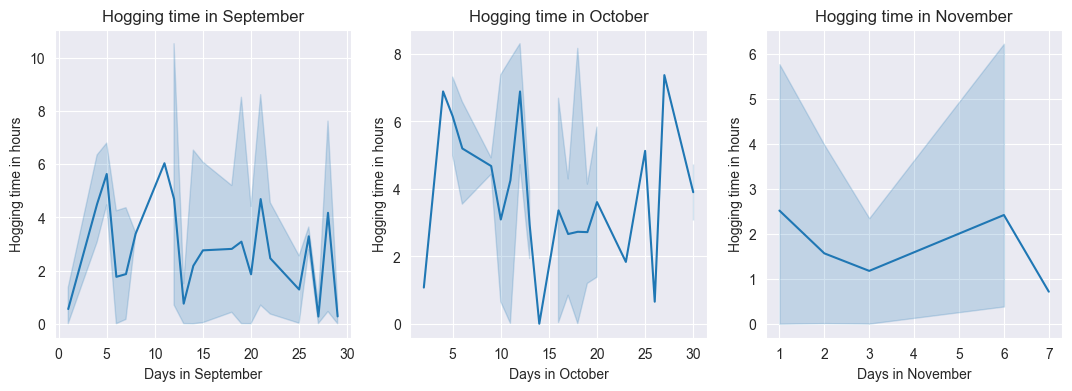

In [93]:
# Rate of charge (daily)
fig, ax = plt.subplots(1, 3, figsize=(13,4))
sns.lineplot(
    data=employee_data_september,
    x='Plugged_in_day',
    y='Hogging time',
    ax=ax[0]
)
ax[0].set_xlabel('Days in September')
ax[0].set_ylabel('Hogging time in hours')
ax[0].set_title('Hogging time in September')

# Rate of charge (weekly)
sns.lineplot(
    data=employee_data_october,
    x='Plugged_in_day',
    y='Hogging time',
    ax=ax[1]
)
ax[1].set_xlabel('Days in October')
ax[1].set_ylabel('Hogging time in hours')
ax[1].set_title('Hogging time in October')

# Rate of charge (monthly)
sns.lineplot(
    data=employee_data_november,
    x='Plugged_in_day',
    y='Hogging time',
    ax=ax[2]
)
ax[2].set_xlabel('Days in November')
ax[2].set_ylabel('Hogging time in hours')
ax[2].set_title('Hogging time in November')
plt.savefig('Images/hogging-time-daily')
plt.show()

In [43]:
#employee_data_november[employee_data_november['Hogging time'] == employee_data_november['Hogging time'].min()]['Hogging time']

Hogging time refers to the period when the vehicle is completely charged but is still plugged to the charge station. All months except November seem to have randomly distributed data. This could be due to the fact that only **7** days in November were recorded. This is also true for charge time and blocking time. In September, the minimum hogging time was **0.002** hours (**10** seconds) and the maximum was **18.42** hours (**18** hours **25** minutes). In October, the minimum hogging time was **0.004** hours (**17** seconds) and the maximum was **8.55** hours (**8** hours **33** minutes). In November, the minimum hogging time was **0.006** hours (**23** seconds) and the maximum hogging time was **6.23** hours (**6** hours **14** minutes).

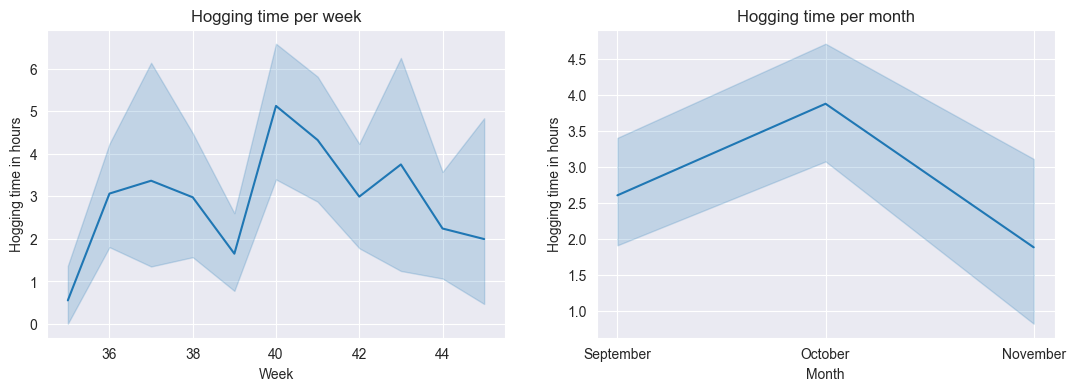

In [120]:
fig, ax = plt.subplots(1, 2, figsize=(13,4))

# Rate of charge (Daily)
# sns.lineplot(
#     data=employee_data,
#     x='Plugged_in_day',
#     y='Blocking time',
#     ax=ax[0]
# )
# ax[0].set_xlabel('Days')
# ax[0].set_ylabel('Blocking time in hours')
# ax[0].set_title('Blocking time (Fig 1.8)')

# Rate of charge (weekly)
sns.lineplot(
    data=employee_data,
    x='Plugged_in_week',
    y='Hogging time',
    ax=ax[0]
)
ax[0].set_xlabel('Week')
ax[0].set_ylabel('Hogging time in hours')
ax[0].set_title('Hogging time per week')

# Rate of charge (monthly)
sns.lineplot(
    data=employee_data,
    x='Plugged_in_month',
    y='Hogging time',
    ax=ax[1]
)
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Hogging time in hours')
ax[1].set_xticks([9, 10, 11], labels=['September', 'October', 'November'])
ax[1].set_title('Hogging time per month')
plt.savefig('Images/hogging-time-weekly-monthly')
plt.show()

The hogging time increased and decreased without a pattern over the course of **8** weeks. From a monthly point of view however, the hogging time increased throughout september and began to decrease from October to November. The hogging and blocking times from October to November had the same decreasing pattern.

### Day-time demand profile

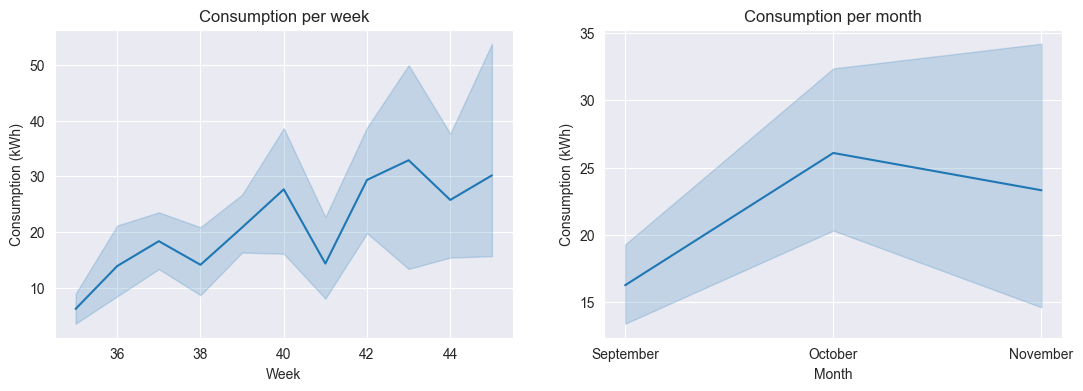

In [121]:
fig, ax = plt.subplots(1, 2, figsize=(13,4))

# Rate of charge (Daily)
# sns.lineplot(
#     data=employee_data,
#     x='Plugged_in_day',
#     y='Blocking time',
#     ax=ax[0]
# )
# ax[0].set_xlabel('Days')
# ax[0].set_ylabel('Blocking time in hours')
# ax[0].set_title('Blocking time (Fig 1.8)')

# Rate of charge (weekly)
sns.lineplot(
    data=employee_data_daytime,
    x='Plugged_in_week',
    y='Verbrauch (kWh)',
    ax=ax[0]
)
ax[0].set_xlabel('Week')
ax[0].set_ylabel('Consumption (kWh)')
ax[0].set_title('Consumption per week')

# Rate of charge (monthly)
sns.lineplot(
    data=employee_data_daytime,
    x='Plugged_in_month',
    y='Verbrauch (kWh)',
    ax=ax[1]
)
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Consumption (kWh)')
ax[1].set_xticks([9, 10, 11], labels=['September', 'October', 'November'])
ax[1].set_title('Consumption per month')
plt.savefig('Images/daytime-demand-profile-weekly-monthly')
plt.show()

In [136]:
#employee_data_daytime[employee_data_daytime['Verbrauch (kWh)'] == employee_data_daytime['Verbrauch (kWh)'].min()]
#employee_data_daytime['Verbrauch (kWh)'].max()

Weekly, there seems to be a positive trend in consumption. This implies that consumption increases overall. It increases in the month of September and peaks in the **43rd** week, which falls in October, at **71 kWh**. It starts to decrease thereafter.

In [97]:
employee_data_weekend[['EVSE-ID', 'Weekend', 'Eingesteckt am', 'Ausgesteckt am', 'Zeit angesteckt', 'Ladedauer', 'Standort', 'Ladestation', 'Verbrauch (kWh)']]

,EVSE-ID,Weekend,Eingesteckt am,Ausgesteckt am,Zeit angesteckt,Ladedauer,Standort,Ladestation,Verbrauch (kWh)
73,DE*ONE*E68JX,Saturday,2023-10-14 16:01:52.768,2023-10-14 16:21:24.712,0h 19m 32s,0h 19m 15s,Ulanweg,ABL_10332049,1.077


For day-time data, only one weekend was recorded, **14th** October. The consumption on Saturday was **1.077 kWh**.

### Nighttime demand profile

In [53]:
employee_data_nighttime_september = employee_data_nighttime[employee_data_nighttime['Plugged_in_month'] == 'September']
employee_data_nighttime_october = employee_data_nighttime[employee_data_nighttime['Plugged_in_month'] == 'October']
employee_data_nighttime_november = employee_data_nighttime[employee_data_nighttime['Plugged_in_month'] == 'November']

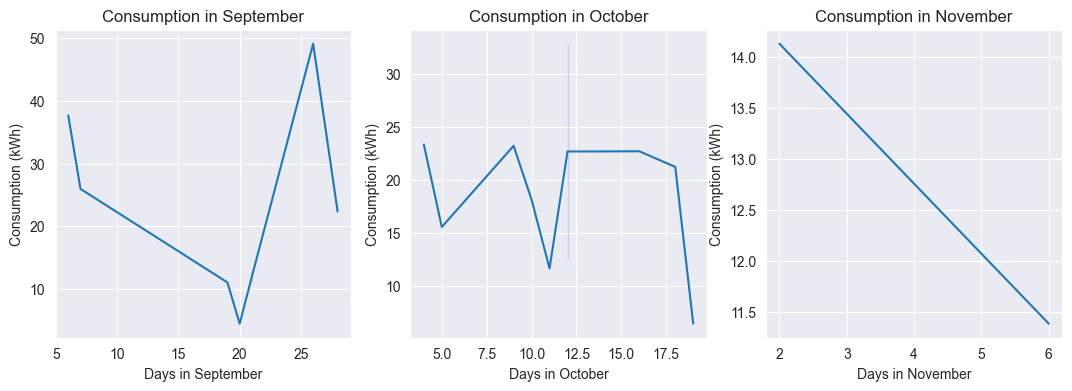

In [99]:
# Rate of charge (daily)
fig, ax = plt.subplots(1, 3, figsize=(13,4))
sns.lineplot(
    data=employee_data_nighttime_september,
    x='Plugged_in_day',
    y='Verbrauch (kWh)',
    ax=ax[0]
)
ax[0].set_xlabel('Days in September')
ax[0].set_ylabel('Consumption (kWh)')
ax[0].set_title('Consumption in September')

# Rate of charge (weekly)
sns.lineplot(
    data=employee_data_nighttime_october,
    x='Plugged_in_day',
    y='Verbrauch (kWh)',
    ax=ax[1]
)
ax[1].set_xlabel('Days in October')
ax[1].set_ylabel('Consumption (kWh)')
ax[1].set_title('Consumption in October')

# Rate of charge (monthly)
sns.lineplot(
    data=employee_data_nighttime_november,
    x='Plugged_in_day',
    y='Verbrauch (kWh)',
    ax=ax[2]
)
ax[2].set_xlabel('Days in November')
ax[2].set_ylabel('Consumption (kWh)')
ax[2].set_title('Consumption in November')
plt.savefig('Images/nighttime-demand-profile-daily')
plt.show()

In [124]:
#employee_data_nighttime_october[employee_data_nighttime_october['Verbrauch (kWh)'] == employee_data_nighttime_october['Verbrauch (kWh)'].max()]
#employee_data_nighttime_november['Verbrauch (kWh)'].max()

In September, consumption (**4.469** kWh) was at its lowest on the **20th** while its highest value was **49.092** kWh on the **26th**. In October, the minimum consumption was **6.393** kWh on the **19th** and the maximum consumption was **32.839** kWh on the **12th**. In November, the consumption rate declined linearly. The minimum being **11.388** kWh and the maximum was **14.133** kWh.

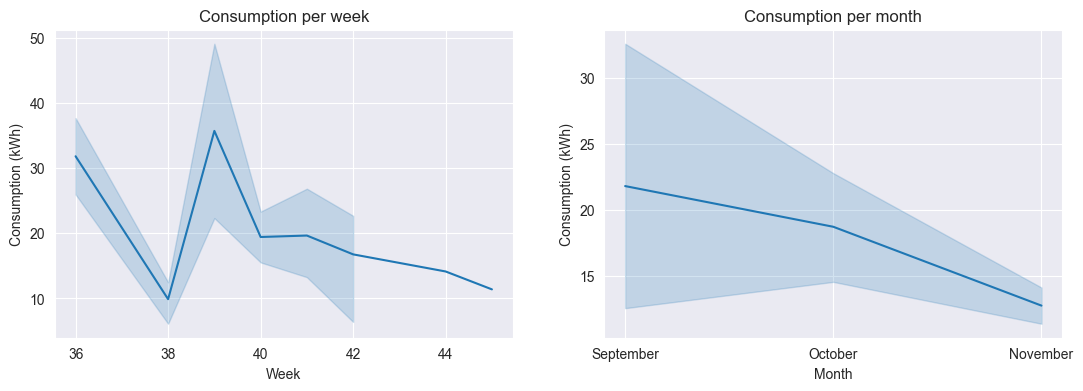

In [122]:
fig, ax = plt.subplots(1, 2, figsize=(13,4))

# Rate of charge (Daily)
# sns.lineplot(
#     data=employee_data,
#     x='Plugged_in_day',
#     y='Blocking time',
#     ax=ax[0]
# )
# ax[0].set_xlabel('Days')
# ax[0].set_ylabel('Blocking time in hours')
# ax[0].set_title('Blocking time (Fig 1.8)')

# Rate of charge (weekly)
sns.lineplot(
    data=employee_data_nighttime,
    x='Plugged_in_week',
    y='Verbrauch (kWh)',
    ax=ax[0]
)
ax[0].set_xlabel('Week')
ax[0].set_ylabel('Consumption (kWh)')
ax[0].set_title('Consumption per week')

# Rate of charge (monthly)
sns.lineplot(
    data=employee_data_nighttime,
    x='Plugged_in_month',
    y='Verbrauch (kWh)',
    ax=ax[1]
)
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Consumption (kWh)')
ax[1].set_xticks([9, 10, 11], labels=['September', 'October', 'November'])
ax[1].set_title('Consumption per month')
plt.savefig('Images/nighttime-demand-profile-weekly-monthly')
plt.show()

In [110]:
#employee_data_nighttime[employee_data_nighttime['Verbrauch (kWh)'] == employee_data_nighttime['Verbrauch (kWh)'].max()]
#employee_data_nighttime['Verbrauch (kWh)'].max()

Week **39** had the highest consumption while week **38** had the lowest consumption. The rate decreased from September to October and further decreased from October to November.

### EV charging load profile

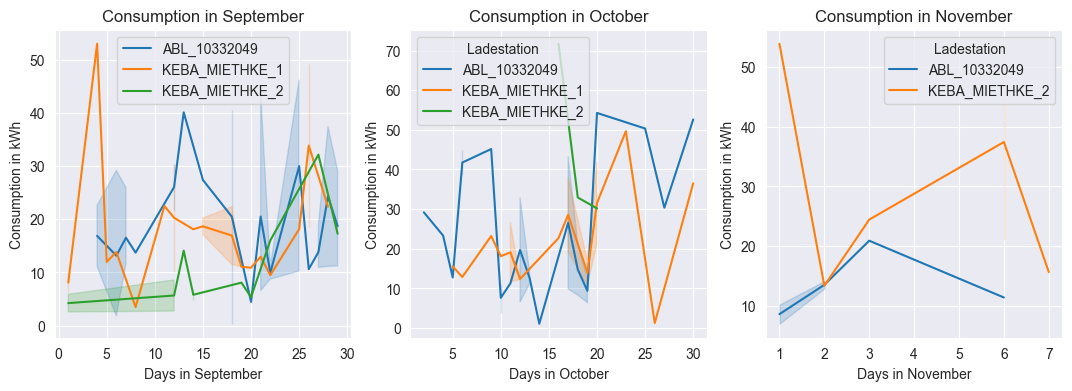

In [198]:
# Rate of charge (daily)
fig, ax = plt.subplots(1, 3, figsize=(13,4))
sns.lineplot(
    data=employee_data_september,
    x='Plugged_in_day',
    y='Verbrauch (kWh)',
    hue='Ladestation',
    ax=ax[0]
)
ax[0].set_xlabel('Days in September')
ax[0].set_ylabel('Consumption in kWh')
ax[0].set_title('Consumption in September')
ax[0].legend(loc='upper center')

# Rate of charge (weekly)
sns.lineplot(
    data=employee_data_october,
    x='Plugged_in_day',
    y='Verbrauch (kWh)',
    hue='Ladestation',
    ax=ax[1]
)
ax[1].set_xlabel('Days in October')
ax[1].set_ylabel('Consumption in kWh')
ax[1].set_title('Consumption in October')

# Rate of charge (monthly)
sns.lineplot(
    data=employee_data_november,
    x='Plugged_in_day',
    y='Verbrauch (kWh)',
    hue='Ladestation',
    ax=ax[2]
)
ax[2].set_xlabel('Days in November')
ax[2].set_ylabel('Consumption in kWh')
ax[2].set_title('Consumption in November')
plt.savefig('Images/EV-charging-load-profile-daily')
plt.show()

In [154]:
EV_loading_time = pd.pivot_table(employee_data, values='Verbrauch (kWh)', columns=['Plugged_in_month', 'Plugged_in_day'], index=['Ladestation'], aggfunc="sum")

In [155]:
EV_loading_time

Plugged_in_month      9                                                   \
Plugged_in_day        1       4       5       6       7       8       11   
Ladestation                                                                
ABL_10332049         NaN  33.735     NaN  52.612  49.564  13.724     NaN   
KEBA_MIETHKE_1    16.152  52.974  23.981  13.835     NaN   3.493  22.478   
KEBA_MIETHKE_2     8.476     NaN     NaN     NaN     NaN     NaN     NaN   

Plugged_in_month                                                          \
Plugged_in_day        12      13      14      15      18      19      20   
Ladestation                                                                
ABL_10332049      52.072  40.084     NaN  27.367  40.976     NaN   4.469   
KEBA_MIETHKE_1    40.558     NaN  18.112  37.330  33.870  22.144  10.886   
KEBA_MIETHKE_2    11.331  14.098  11.610     NaN     NaN   8.084  10.712   

Plugged_in_month                                                         \
Plugged_in_day        21      22      25      26      27     28      29   
Ladestation                                                               
ABL_10332049      61.479  19.844  89.950  10.619  41.445  48.57  56.069   
KEBA_MIETHKE_1    12.957   9.482  18.139  67.702     NaN  22.33     NaN   
KEBA_MIETHKE_2       NaN  16.018     NaN     NaN  32.135    NaN  17.266   

Plugged_in_month      10                                                  \
Plugged_in_day        2       4       5       6       9       10      11   
Ladestation                                                                
ABL_10332049      29.181  23.322  12.744  83.482  45.145  15.224  11.276   
KEBA_MIETHKE_1       NaN     NaN  15.529  12.858  23.195  18.115  38.164   
KEBA_MIETHKE_2       NaN     NaN     NaN     NaN     NaN     NaN     NaN   

Plugged_in_month                                                         \
Plugged_in_day        12      13     14      16      17      18      19   
Ladestation                                                               
ABL_10332049      39.352  25.121  1.077     NaN  53.107  29.501  18.753   
KEBA_MIETHKE_1    24.706     NaN    NaN  22.680  57.106     NaN  27.813   
KEBA_MIETHKE_2       NaN     NaN    NaN  71.712     NaN  32.924     NaN   

Plugged_in_month                                                     11  \
Plugged_in_day        20      23      25     26      27      30      1    
Ladestation                                                               
ABL_10332049      54.254     NaN  50.321    NaN  30.342  52.600  17.195   
KEBA_MIETHKE_1    63.105  49.646     NaN  1.237     NaN  36.507     NaN   
KEBA_MIETHKE_2    30.166     NaN     NaN    NaN     NaN     NaN  53.874   

Plugged_in_month                                 
Plugged_in_day        2       3       6      7   
Ladestation                                      
ABL_10332049      27.014  20.895  11.388    NaN  
KEBA_MIETHKE_1       NaN     NaN     NaN    NaN  
KEBA_MIETHKE_2    13.349  24.428  74.849  15.64

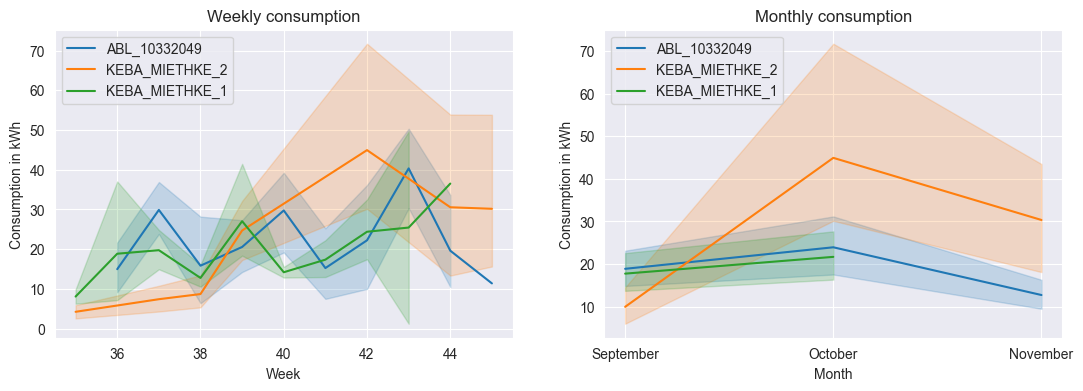

In [143]:
# Rate of charge (daily)
fig, ax = plt.subplots(1, 2, figsize=(13,4))
sns.lineplot(
    data=employee_data,
    x='Plugged_in_week',
    y='Verbrauch (kWh)',
    hue='Ladestation',
    ax=ax[0]
)
ax[0].set_xlabel('Week')
ax[0].set_ylabel('Consumption in kWh')
ax[0].set_title('Weekly consumption')
ax[0].legend(loc='upper left')

# Rate of charge (weekly)
sns.lineplot(
    data=employee_data,
    x='Plugged_in_month',
    y='Verbrauch (kWh)',
    hue='Ladestation',
    ax=ax[1]
)
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Consumption in kWh')
ax[1].set_title('Monthly consumption')
ax[1].set_xticks([9, 10, 11], labels=['September', 'October', 'November'])
ax[1].legend(loc='upper left')
plt.savefig('Images/EV-charging-load-profile-weekly-monthly')
plt.show()

### Charge Volume/Energy Uptake in kWh per charge point

In [223]:
energy_uptake_charge_point_weekly = pd.pivot_table(employee_data, values='Verbrauch (kWh)', columns=['Anschluss'], index=['Plugged_in_week'], aggfunc="sum")

In [227]:
energy_uptake_charge_point_weekly.fillna(0, inplace=True)

In [230]:
energy_uptake_charge_point_weekly['Sum'] = energy_uptake_charge_point_weekly.sum(axis=1)
energy_uptake_charge_point_weekly

Anschluss,Ladepunkt 1,Ladepunkt 2,Ladepunkt 3,Ladepunkt 4,Sum
Plugged_in_week,,,,,
35,8.476,0.000,16.152,0.000,24.628
36,13.835,89.783,55.907,84.393,243.918
37,101.484,38.698,21.644,113.214,275.040
38,59.078,63.415,33.716,94.712,250.921
39,112.497,28.890,81.948,180.890,404.225
40,15.529,29.181,51.320,81.086,177.116
41,59.935,29.708,56.625,95.107,241.375
42,128.502,207.522,64.450,60.647,461.121
43,0.000,1.237,0.000,130.309,131.546


In [235]:
energy_uptake_charge_point_monthly = pd.pivot_table(employee_data, values='Verbrauch (kWh)', columns=['Plugged_in_month'], index=['Anschluss'], aggfunc="sum")

In [236]:
energy_uptake_charge_point_monthly.columns = ['September', 'October', 'November']

In [238]:
energy_uptake_charge_point_monthly['Sum'] = energy_uptake_charge_point_monthly.sum(axis=1)
energy_uptake_charge_point_monthly

,September,October,November,Sum
Anschluss,,,,
Ladepunkt 1,295.370,240.473,109.141,644.984
Ladepunkt 2,220.786,267.648,100.892,589.326
Ladepunkt 3,209.367,172.395,25.521,407.283
Ladepunkt 4,473.209,419.749,23.078,916.036


### Charge utilization

In [167]:
employee_data['Charge utilization'] = employee_data['Charge time'] / employee_data['Blocking time']

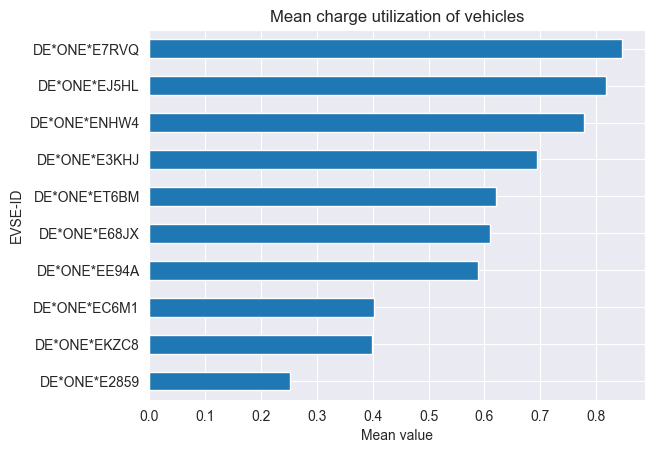

In [239]:
employee_data.groupby('EVSE-ID')['Charge utilization'].mean().sort_values(ascending=True).plot(kind='barh')
plt.title('Mean charge utilization of vehicles')
plt.xlabel('Mean value')
plt.savefig('Images/charge-utilization')
plt.show()

### Connection vs Charging time

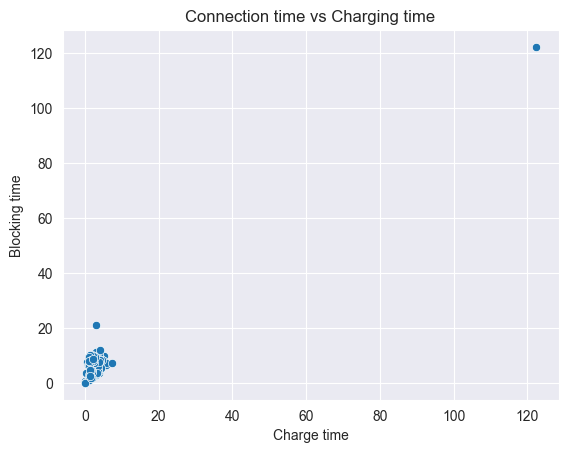

In [189]:
sns.scatterplot(
    data=employee_data,
    x='Charge time',
    y='Blocking time'
)
plt.title('Connection time vs Charging time')
plt.savefig('Images/connection-vs-charging-time-1')
plt.show()

In [187]:
employee_data_without_122_hr = employee_data.drop(index=63)

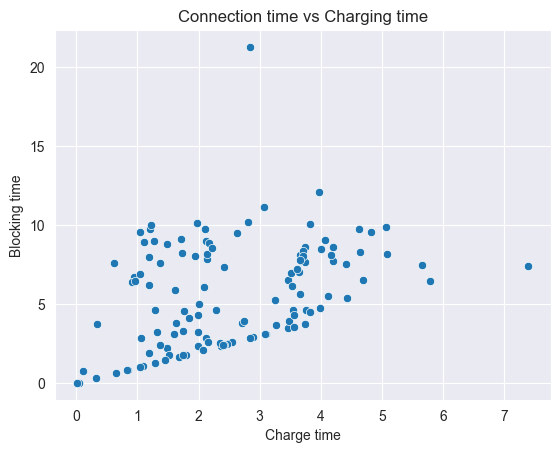

In [190]:
sns.scatterplot(
    data=employee_data_without_122_hr,
    x='Charge time',
    y='Blocking time'
)
plt.title('Connection time vs Charging time')
plt.savefig('Images/connection-vs-charging-time-2')
plt.show()

### Rate of employee usage after 6pm

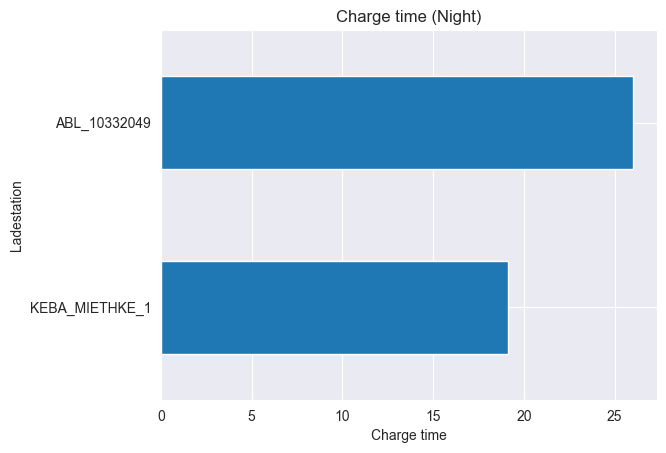

In [246]:
employee_data_nighttime.groupby('Ladestation')['Charge time'].sum().sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Charge time')
plt.title('Charge time (Night)')
plt.savefig('Images/rate-of-employee-usage-at-night')
plt.show()

### Amount of charge stations vs connections

In [252]:
amount_of_charge_stations = employee_data.groupby('Ladestation')['Anschluss'].unique()

In [253]:
df = pd.DataFrame(amount_of_charge_stations)

In [254]:
df

,Anschluss
Ladestation,
ABL_10332049,"[Ladepunkt 3, Ladepunkt 4, Ladepunkt 2, Ladepu..."
KEBA_MIETHKE_1,"[Ladepunkt 1, Ladepunkt 2, Ladepunkt 4, Ladepu..."
KEBA_MIETHKE_2,"[Ladepunkt 2, Ladepunkt 1]"
